In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

# ! pip install -q segmentation-models-pytorch

# ! pip install -q segmentation-models-pytorch
# ! pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp



In [2]:
from sys import platform

#setting the device in the corresponding accelerator depending ion the OS 
if platform == "linux" or platform == "linux2" or platform=='wind32':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device on cuda') if torch.cuda.is_available() else print(f'device on cpu') 
elif platform == "darwin":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f'device on mps') if torch.backends.mps.is_available() else print(f'device on cpu') 

device on mps


In [3]:
import matplotlib.pyplot as plt
import cv2
import PIL
import numpy as np
from PIL import Image
import os 
import shutil
import json
from IPython.display import display
from pathlib import Path, fnmatch
from IPython.core.debugger import set_trace
%matplotlib inline


In [19]:
img =  cv2.imread(image_path, 0)

In [4]:
test_image ='/Users/souayb/Desktop/Ginkgo/HACK_GEO/archive/dataset/semantic_drone_dataset/label_images_semantic/000.png'
test_image_origin = '/Users/souayb/Desktop/Ginkgo/HACK_GEO/archive/dataset/semantic_drone_dataset/original_images/000.jpg'
test_image_color = '/Users/souayb/Desktop/Ginkgo/HACK_GEO/archive/RGB_color_image_masks/RGB_color_image_masks/000.png'

In [28]:
img_test =  cv2.imread(test_image, 0)
img_test_oring =  cv2.imread(test_image_origin, 0)
img_test_colored =  cv2.imread(test_image_color, 0)

In [5]:
def im_read(path):
    image = PIL.Image.open(path)
    return np.array(image)

In [6]:
img_test =  im_read(test_image)
img_test_oring =  im_read(test_image_origin)
img_test_colored =  im_read(test_image_color)

In [9]:
np.unique(img_test)

array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,30))
ax[0].imshow(img_test)
ax[2].imshow(img_test_oring)
ax[1].imshow(img_test_colored)


In [21]:
saved_M = torch.load('/Users/souayb/Desktop/Ginkgo/HACK_GEO/saved_models/Unet-Mobilenet_v2_mIoU-0.439.pt')
save_model = torch.load('saved_models/Unet-Mobilenet_v2_mIoU-0.382.pt')

In [10]:
class TestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [11]:
MASK_PATH  = 'archive/dataset/semantic_drone_dataset/label_images_semantic/'
IMAGE_PATH = 'archive/dataset/semantic_drone_dataset/original_images/'

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = TrainData(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = TrainData(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [13]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [14]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


In [15]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = TestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [17]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [18]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [19]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [22]:
mob_miou = miou_score(save_model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/souayb/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/functional.py:3938: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1677744624671/work/aten/src/ATen/native/mps/operations/UpSample.mm:233.)
  return torch._C._nn.upsample_nearest2d(input, output_size, scale_factors)
/var/folders/_0/2fxtv7g55_j9h6ygr5nd3gf40000gp/T/ipykernel_10482/2809514705.py:19: UserWarning: MPS: no support for int64 for sum_out_mps, casting to int32. Support has been added in macOS 13.3 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1677744624671/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:142.)
  if true_label.long().sum().item() == 0: #no exist label in this loop


In [23]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(save_model, image, mask)

In [25]:
np.unique(pred_mask)

array([ 0,  1,  2,  3,  4,  8,  9, 10, 13, 15, 17, 21, 22])

In [24]:
mob_acc = pixel_acc(save_model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

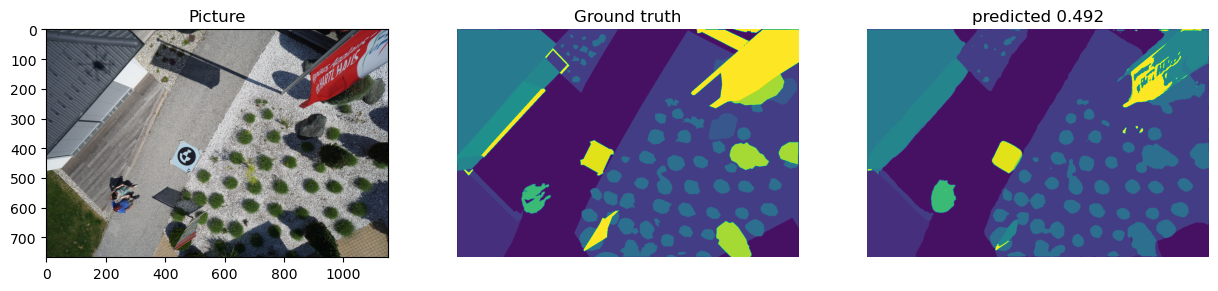

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)    
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('predicted {:.3f}'.format(score))
ax3.set_axis_off()

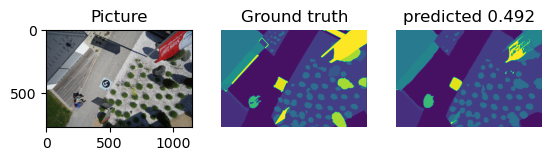

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)    
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('predicted {:.3f}'.format(score))
ax3.set_axis_off()

In [7]:
image_path = "project-1-at-2023-03-03-13-48-a1042468/dop10rgbi_32_287_5661_1_nw_2021.jpeg"
json_path = "project-1-at-2023-03-03-13-48-a1042468/result.json"

In [ ]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(save_model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

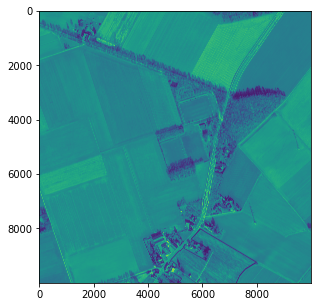

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(img)

In [63]:
def predict_image_mask_pixel(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Predicts a segmentation mask for the given input image using the specified model.

    Args:
    - model: A PyTorch model object that takes an image tensor as input and outputs a segmentation mask tensor.
    - image: A PIL Image object or a NumPy array containing the input image.
    - mean: A list of three floats representing the mean values for the three color channels used for normalization. Default is [0.485, 0.456, 0.406].
    - std: A list of three floats representing the standard deviation values for the three color channels used for normalization. Default is [0.229, 0.224, 0.225].

    Returns:
    - A NumPy array representing the predicted segmentation mask for the input image.
    """
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked 

def image_tiler(model,image_path, tile_size=512 ):
    """
    Predicts a segmentation mask for a large image by breaking it into smaller tiles, predicting a mask for each tile, and then stitching the tiles together.

    Args:
    - model: A PyTorch model object that takes an image tensor as input and outputs a segmentation mask tensor.
    - image_path: A string representing the file path to the input image.
    - tile_size: An integer representing the size of the square tiles to break the image into. Default is 512.

    Returns:
    - A NumPy array representing the predicted segmentation mask for the input image.
    """
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Calculate the number of tiles in each dimension
    num_tiles_x = img.shape[0] // tile_size
    num_tiles_y = img.shape[1] // tile_size
    
    # Calculate the amount of padding needed for the last row and column
    pad_x = tile_size - img.shape[0] % tile_size
    pad_y = tile_size - img.shape[1] % tile_size
    
    # Pad the image if necessary
    img = np.pad(img, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')
    
    result = np.zeros((num_tiles_x, num_tiles_y, tile_size, tile_size), dtype=np.float32)
    
    # Loop through the image and create tiles
    for tile_x in range(num_tiles_x):
        interme_result = np.zeros((num_tiles_y, tile_size, tile_size), dtype=np.float32)
        for tile_y in range(num_tiles_y):
            # Calculate the slice indices for this tile
            x_slice = slice(tile_x*tile_size, (tile_x+1)*tile_size)
            y_slice = slice(tile_y*tile_size, (tile_y+1)*tile_size)
           
            # Slice the array to get this tile
            tile = img[x_slice, y_slice,:]
            mask = predict_image_mask_pixel(model=model, image=tile)
            
            interme_result[tile_y] = mask.detach().cpu().numpy()
        
        # Assign the tiles to the corresponding slice in the result array
        result[tile_x] = interme_result
    
    
    result = np.hstack(result )
    print(result.shape)
    result = np.hstack(result)
    
    return result


In [67]:
def im_read(path):
    image = PIL.Image.open(path)
    return np.array(image)

In [68]:
original_img = im_read(image_path)

/Users/souayb/miniconda3/envs/pytorch/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [72]:
rr_img = Image.fromarray(rr)
rr_img = rr_img.convert("L")
rr_img.save('test_test.png')

In [64]:
rr=  image_tiler(model=save_model, image_path=image_path)

(19, 9728, 512)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


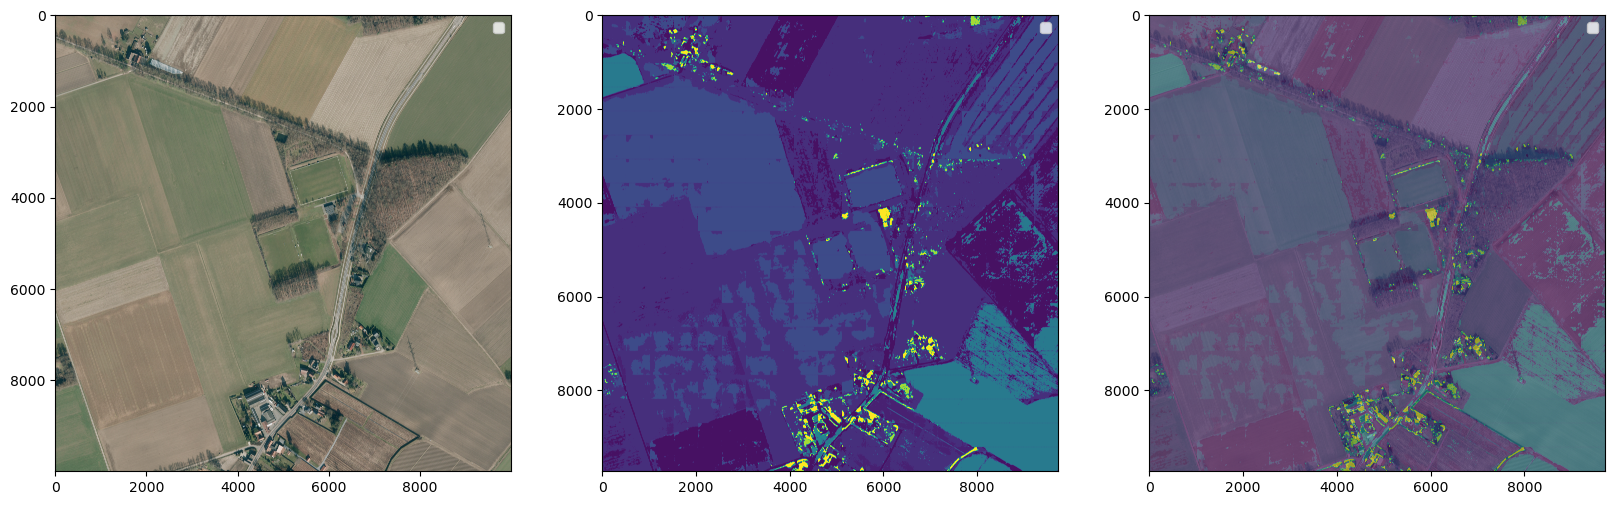

In [89]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
ax[0].imshow(original_img, label='Original image')
ax[1].imshow(rr, label='Predicted mask')
ax[2].imshow(original_img, label='Predicted mask')
ax[2].imshow(rr, label='Overlaping the image with orignal', alpha=0.6)
ax[0].legend()
ax[1].legend()
ax[2].legend()

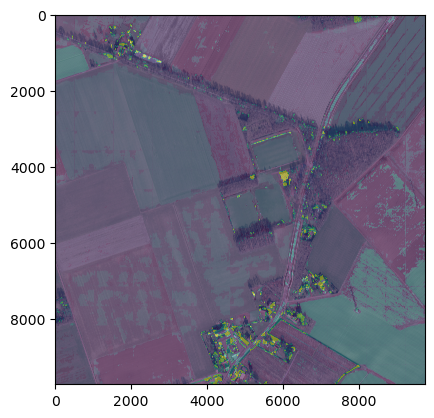

In [78]:
plt.imshow(original_img)
plt.imshow(rr, alpha=0.5)
plt.show()

In [ ]:
#img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
img = cv2.imread(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [60]:
aaa = np.hstack(rrr )
print(aaa.shape)
aaa = np.hstack(aaa)
aaa.shape

(19, 9728, 512)


(9728, 9728)

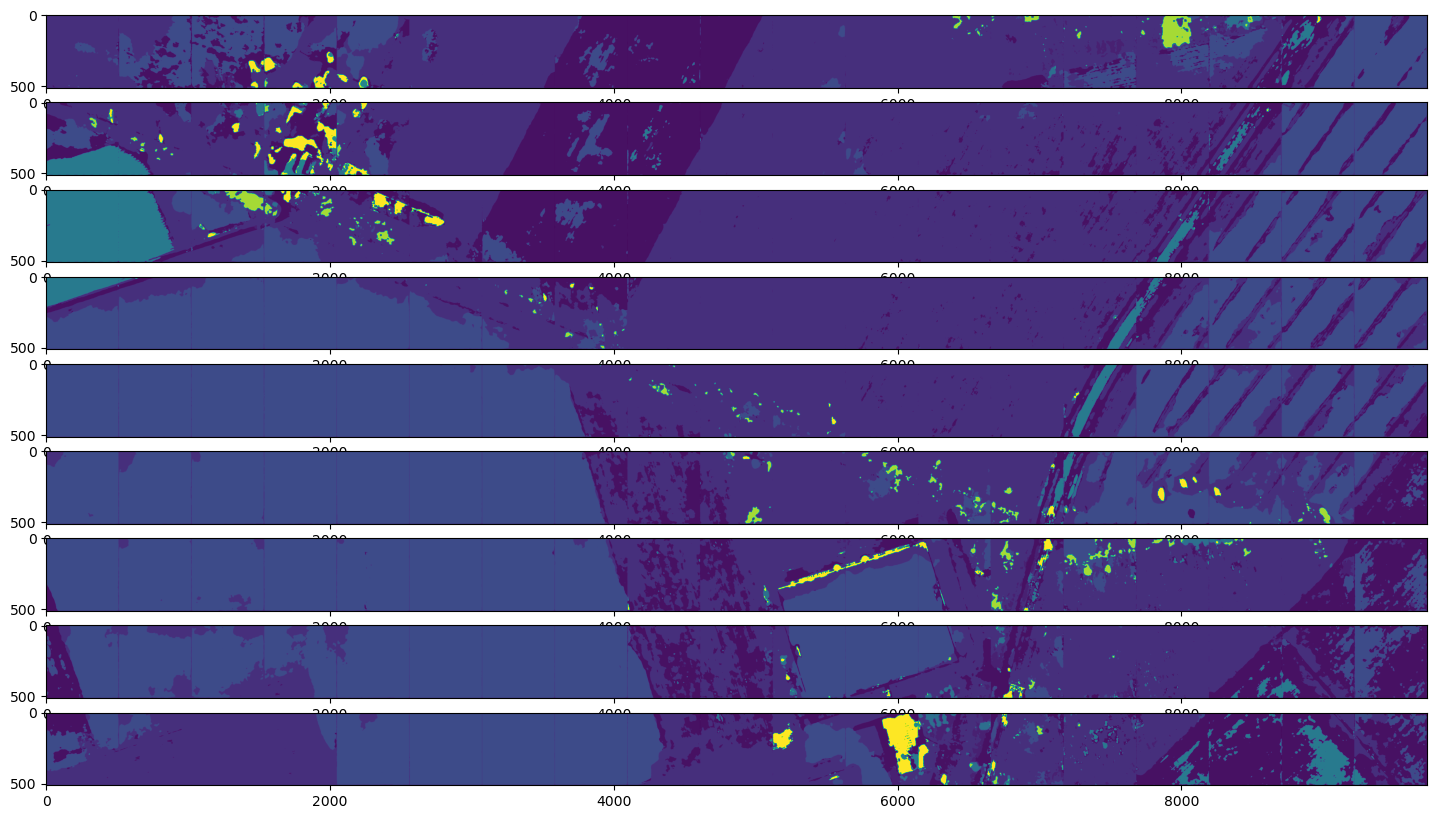

In [45]:
fig , ax = plt.subplots(nrows=9, ncols=1, figsize=(20,10))
for i in range(9):
   
    img_tmp = rrr[i]
    img_tmp = np.concatenate(img_tmp, axis=-1)
    ax[i].imshow(img_tmp)

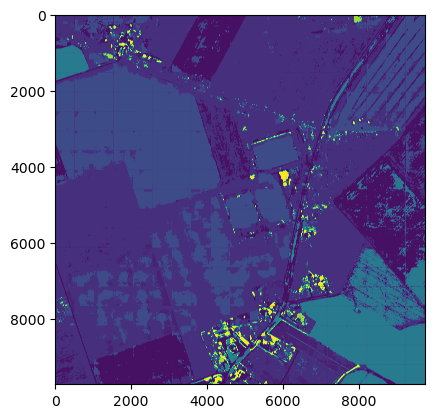

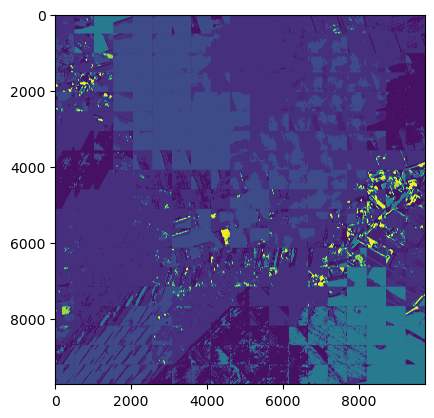

In [34]:
plt.imshow(rrr)

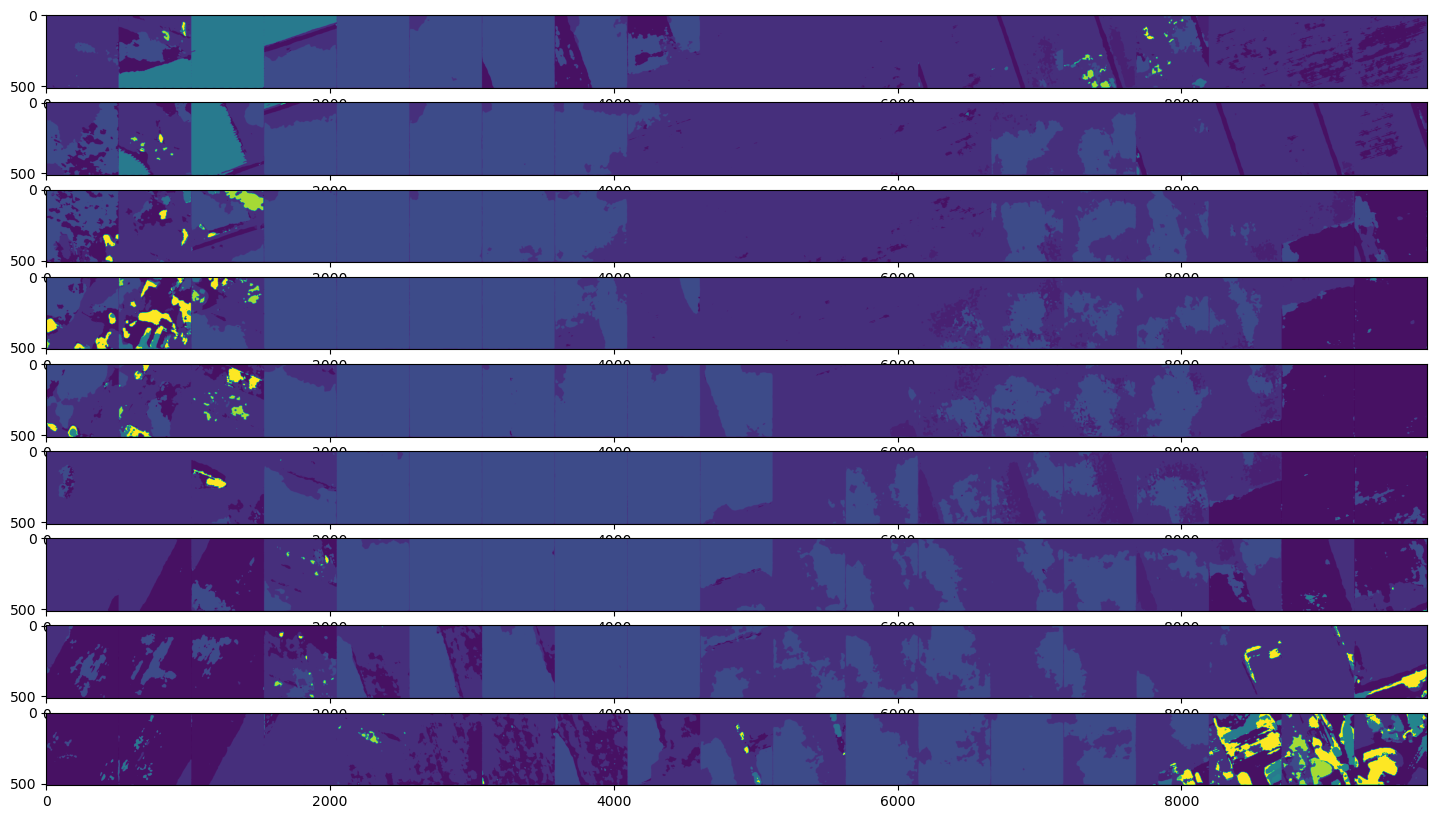

In [25]:
fig , ax = plt.subplots(nrows=9, ncols=1, figsize=(20,10))
for i in range(9):
   
    img_tmp = rrr[i]
    img_tmp = np.concatenate(img_tmp, axis=-1)
    ax[i].imshow(img_tmp)

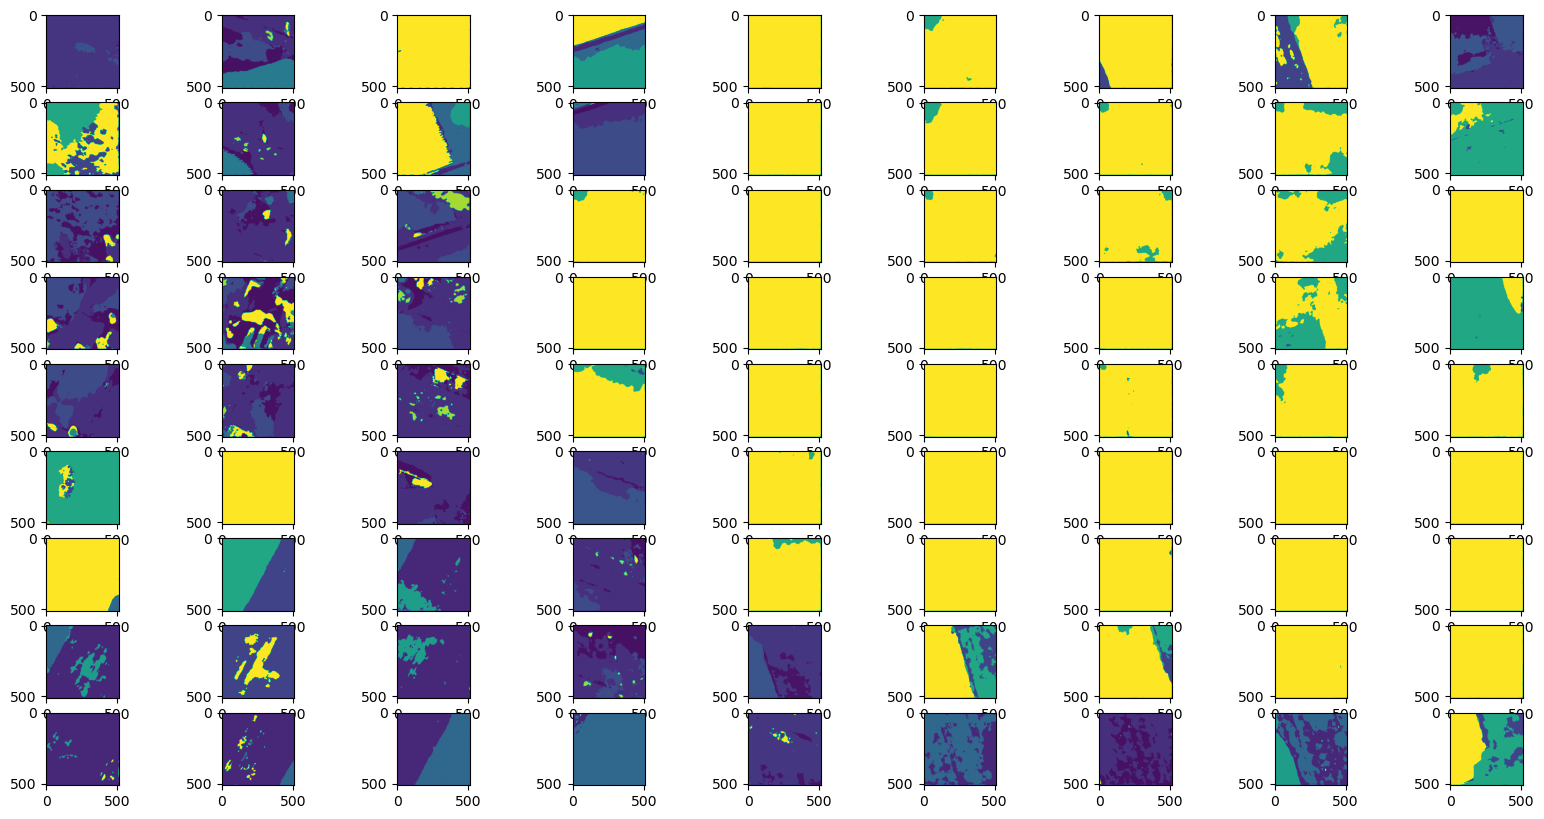

In [24]:
fig , ax = plt.subplots(nrows=9, ncols=9, figsize=(20,10))
for i in range(9):
  for j in range(9):
    img_tmp = rrr[i][j]

    # img_tmp = np.transpose(img_tmp, axes=[2,1,0])
    ax[i,j].imshow(img_tmp)

In [24]:
  
# define a main function
def main():
    array = np.zeros((200,200))
    
    print(array.shape)
      
   
    # show the shape of the array
    print(array.shape)

    data = Image.fromarray(np.np.uint8(array),mode='L')
    data.save('gfg_dummy_pic.png')

In [25]:
main()

(200, 200)
(200, 200)


AttributeError: module 'numpy' has no attribute 'np'

In [13]:
import json
from pycocotools import mask as maskUtils # pip install pycocotools

def create_mask(poly, im_height, im_width):
    ## assuming binary_mask is a numpy array with shape (height, width, channels)
    binary_mask = maskUtils.decode(maskUtils.frPyObjects(poly, im_height, im_width))
    grayscale_mask = np.mean(binary_mask, axis=2)
    img = Image.fromarray(np.uint8(grayscale_mask * 255), mode='L')
    return img



def Get_COCO_Data(imgpath, anno_path=None, dst:str=None, class_name="asphalt", category_id = 0):
    """
    This function create a binary susing polygone information 

    """
    if not os.path.isdir(dst):
        raise NotADirectoryError("The input need to be an existing directory")
    
    with open(anno_path, 'r') as f:
        results = json.load(f)
    
    for image, annotation in zip(results['images'],results["annotations"]):

        im_width = image["width"]
        im_height = image["height"]
        im_id = image["id"]
        im_name = Path(image["file_name"]).stem
        im_extend = Path(image["file_name"]).suffix
        im_mask = im_name + '_mask'
        
        #reading the Image Daniel
        ############ start ###########

        #### END #######################


        #Creating the binary mask 
        # if the match the given class 
        if annotation["category_id"] ==category_id:
            poly = annotation["segmentation"]
            im_mask = create_mask(poly, im_height=im_height, im_width=im_width)
        else : # only dark image 
            array = np.zeros((im_height, im_width))
            img = Image.fromarray(np.uint8(array),mode='L')

        ################## tiling the image #######################

            

        ###################### end tiling #########################

        ################# saving the tiled (images and mask)
        

In [17]:
image = Image.fromarray(np.uint8(binary_mask * 255), mode='L')
image.save('binary_mask.png')


ValueError: Too many dimensions: 3 > 2.

In [10]:
def resizeNumpy(arr,size=(512,512)):
    if isinstance(arr, np.ndarray): 
        im = Image.fromarray(arr)
    else :
        im = arr
    im = im.resize(size)
    return im
            
def get_poly(poly_path):
    try :
        
        with open(poly_path) as jsonfile:
            poly_dicts= json.load(jsonfile)
    except UnicodeDecodeError:
        with open(poly_path, encoding='latin-1') as jsonfile:
            poly_dicts= json.load(jsonfile)
    return poly_dicts['shapes']

def read_image(path, fromcv:str=True):
    if fromcv:
        return cv2.imread(path, 0)
    else :
        image = PIL.Image.open(path)
        return np.array(image)


def create_mask(inputpath, dst:str):
    dirlists = os.listdir(inputpath)
    
    for inpath in dirlists:
        currentdir = os.path.join(inputpath, inpath)
        if not os.path.isdir(currentdir):
            continue
        filelists   = [ file for file in os.listdir(currentdir) if file.endswith(('.jpg', '.jpeg', '.tif','.gif', '.png'))]
        if not filelists :
            continue
#         class_lists = ['arm', 'head','foot']
        class_lists = ['head']
        if not os.path.isdir(dst):
            Path(dst).mkdir(parents=True, exist_ok=True)

        if not os.path.isdir(os.path.join(dst, 'img')):
            os.mkdir(os.path.join(dst, 'img'))
            os.mkdir(os.path.join(dst, 'annot'))
        for file in filelists:

            stemname = Path(file).stem
            #readin the image 
            impath = os.path.join(currentdir, file)
            img = read_image(impath)
            #reading the poygone

            polypath = os.path.join(currentdir, stemname+'.json')
            if not Path(polypath).exists():
                continue
            poly = get_poly(polypath)
            # getting the file 
            mask = np.zeros(shape= (img.shape[0],img.shape[1]), dtype=np.float32)
            for shape in poly:
                if shape['label'] in class_lists:
                    points = np.array(shape['points'], dtype=np.int32)
                    cv2.fillPoly(mask, [points], 255)
            #set_trace()
            mask = PIL.Image.fromarray(mask)
            mask  = mask.convert("L")
            img = resizeNumpy(img)
            mask= resizeNumpy(mask)
            img.save(os.path.join(dst,'img', stemname+'.png'))
            mask.save(os.path.join(dst,'annot', stemname+'.png'))



In [ ]:
def create_mask(imag_path, json_path, dst:str):
   
    class_lists = ['head']
    if not os.path.isdir(dst):
        Path(dst).mkdir(parents=True, exist_ok=True)

    if not os.path.isdir(os.path.join(dst, 'img')):
        os.mkdir(os.path.join(dst, 'img'))
        os.mkdir(os.path.join(dst, 'annot'))
 

    stemname = Path(imag_path).stem
    #readin the image 
    
    img = read_image(image_path)
                     
    #reading the poygone
    poly = get_poly(json_path)
    # getting the file 
    
    mask = np.zeros(shape= (img.shape[0],img.shape[1]), dtype=np.float32)
    for shape in poly:
        if shape['label'] in class_lists:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], 255)
    #set_trace()
    mask = PIL.Image.fromarray(mask)
    mask  = mask.convert("L")
    img = resizeNumpy(img)
    mask= resizeNumpy(mask)
    img.save(os.path.join(dst,'img', stemname+'.png'))
    mask.save(os.path.join(dst,'annot', stemname+'.png'))

In [4]:
#@save
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [6]:
!ls

Untitled.ipynb
